# Milk Production - Time Series Forecasting

***
_**Importing the required libraries & packages**_

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima
import pickle
import warnings
warnings.filterwarnings('ignore')

_**Changing The Default Working Directory Path & Reading the Dataset using Pandas Command along with that changing the index column with `Month` column and also changing the data type of `Month` column as <span style="color:red">DateTime</span>**_

In [2]:
os.chdir('C:\\Users\\Shridhar\\Desktop\\Milk Production Project')
df = pd.read_csv('monthly-milk-production.csv',parse_dates = ['Month'],index_col = 'Month')

## Exploratory Data Analysis(EDA)

_**Checking the data type of the column in the dataset**_

In [3]:
df.dtypes

Milk Production    float64
dtype: object

_**Getting the shape of the dataset**_

In [4]:
df.shape

(168, 1)

_**Checking for the null values in the column from the dataset**_

In [5]:
df.isna().sum()

Milk Production    0
dtype: int64

_**Getting the summary of various descriptive statistics for the numeric column in the dataset**_

In [6]:
df.describe()

,Milk Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


## Data Visualization

_**Plotting the line graph to show the data trend in the dataset and saving the graph as PNG file**_

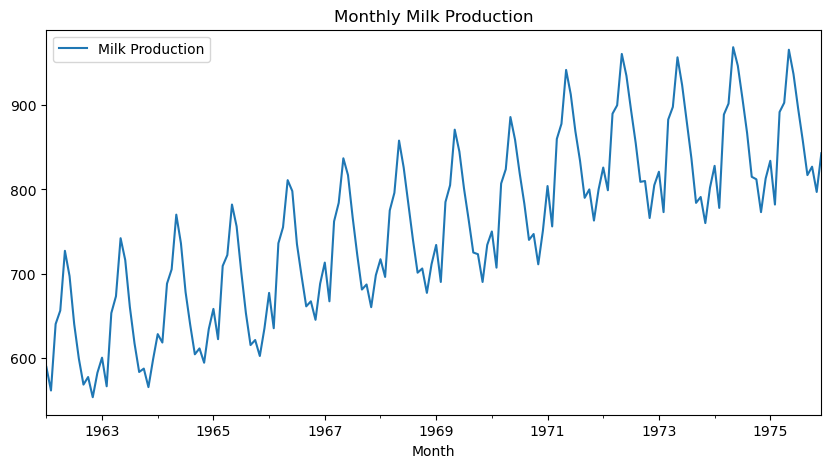

In [7]:
df.plot(figsize =(10, 5))
plt.title('Monthly Milk Production')
plt.savefig('Monthly Milk Production.png')
plt.show()

_**Plotting the histogram and KDE line graph to show the distribution of data in the dataset and saving the graph as PNG file**_

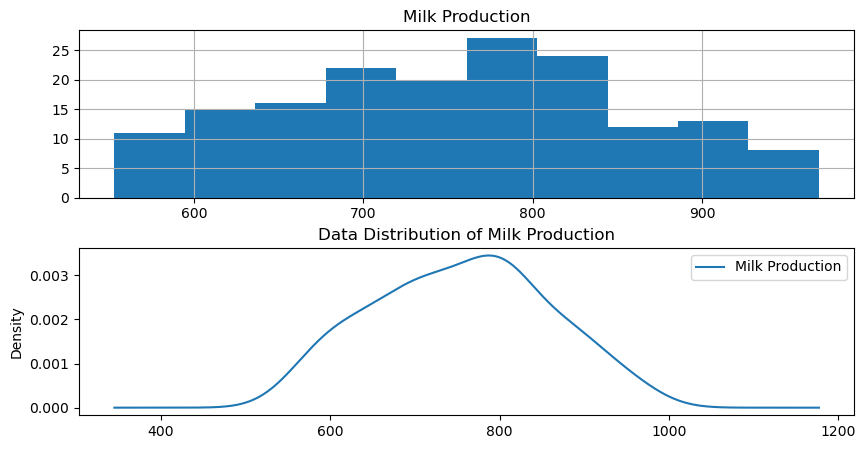

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10, 5))
df.hist(ax = ax1)
df.plot(kind = 'kde', ax = ax2 )
plt.title('Data Distribution of Milk Production')
plt.savefig('Data Distribution of Milk Production.png')
plt.show()

_**Plotting the graph with "Seasonal Decompose" function to show the Data Description, Trend, Seasonal, Residuals and saving the graph as PNG file**_

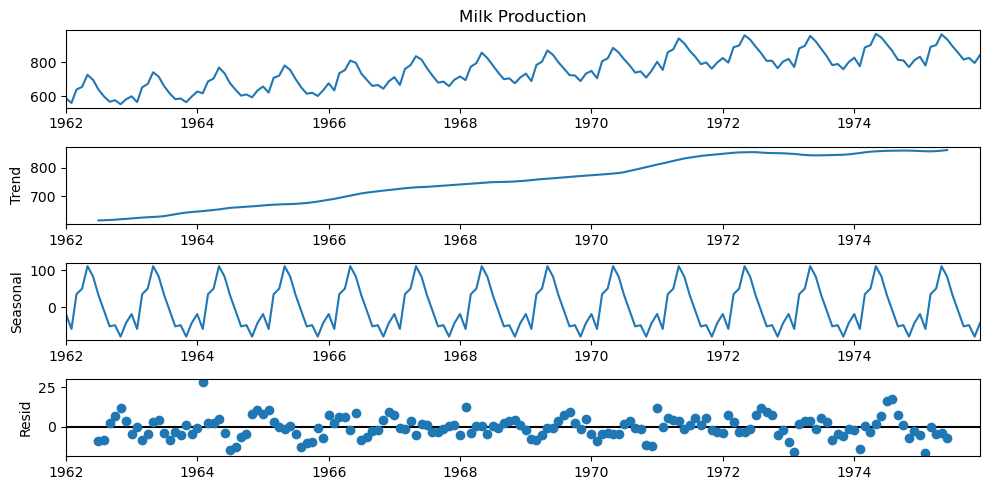

In [9]:
plt.rcParams['figure.figsize'] = 10, 5
decomposition = seasonal_decompose(df['Milk Production'], period = 12, model = 'additive')
decomposition.plot()
plt.savefig('Trend, Seasonal, Residual Graph.png')
plt.show()

_**Plotting the graphs with Auto-Correlation and Partial Auto-Correlation of the data from the dataset and saving the graphs as PNG file**_

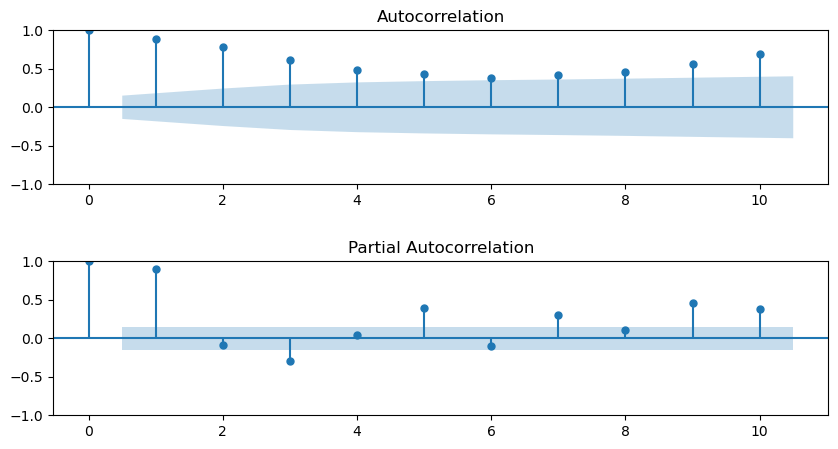

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10, 5))
ax1 = plot_acf(df['Milk Production'], lags = 10, ax = ax1)
ax2 = plot_pacf(df['Milk Production'], lags = 10, ax = ax2)
plt.subplots_adjust(hspace = 0.5)
plt.savefig('ACF & PACF.png')
plt.show()

## Data Tranmsformation

_**The `adf_check()` function performs an Augmented Dickey-Fuller test on a time series. The test is used to determine whether a time series is stationary or not. If the p-value of the test is less than or equal to 0.05, then there is strong evidence against the null hypothesis, and the series is considered to be stationary. Otherwise, the series is considered to be non-stationary.
The function takes a time series as input and returns the results of the test. The results are printed to the console, along with a message indicating whether the series is stationary or not.**_

In [11]:
def adf_check (time_series):
    result = adfuller (time_series)
    print ('Augmented Dickey Fuller Test :')
    labels = ['ADF Test Statistics', 'P Value', 'Number of Lags Used','Number of Observations']
    for value, label in zip(result, labels):
        print (label +' : '+ str (value))
    if result [1] <= 0.05:
        print ('Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary ')
    else:
        print ('Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary ')

_**Performing the Augmented Dickey-Fuller test on the original data in the dataset to find whether the time series is stationary or not**_

In [12]:
adf_check(df['Milk Production'])

Augmented Dickey Fuller Test :
ADF Test Statistics : -1.3038115874221268
P Value : 0.6274267086030328
Number of Lags Used : 13
Number of Observations : 154
Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary 


_**Since the Time Series is Not Stationary, the dataset is transformed as a new DataFrame with First Differene and Seasonal First Difference to make it as a Stationary Series**_

In [13]:
df1 = df.diff().diff(12).dropna()

_**Performing again the Augmented Dickey-Fuller test on the new transformed data from the dataset to find whether the time series is stationary or not**_

In [14]:
adf_check(df1['Milk Production'])

Augmented Dickey Fuller Test :
ADF Test Statistics : -5.0380022749219755
P Value : 1.865423431878904e-05
Number of Lags Used : 11
Number of Observations : 143
Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary 


_**Plotting the line graph to show the data trend in the transformed data from the dataset and saving the graph as PNG file**_

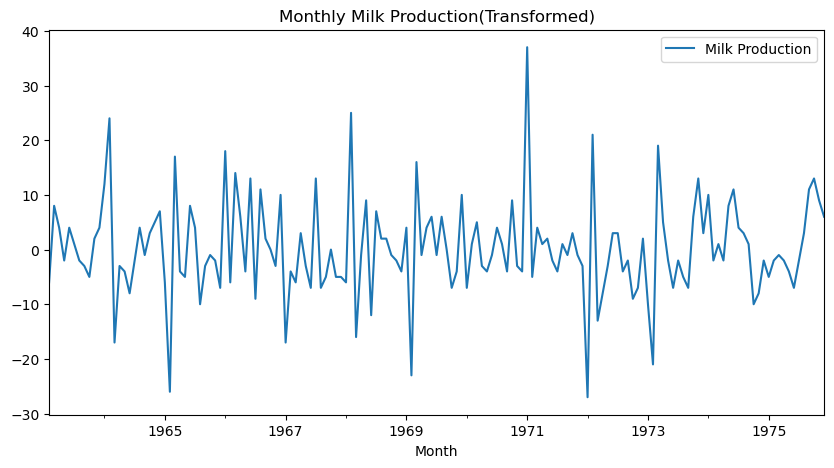

In [15]:
df1.plot(figsize =(10, 5))
plt.title('Monthly Milk Production(Transformed)')
plt.savefig('Monthly Milk Production(Transformed).png')
plt.show()

_**Plotting the graph with pandas plotting autocorrelation_plot to show the difference between the Stationary Data and Non-Stationary Data and saving it as PNG file**_

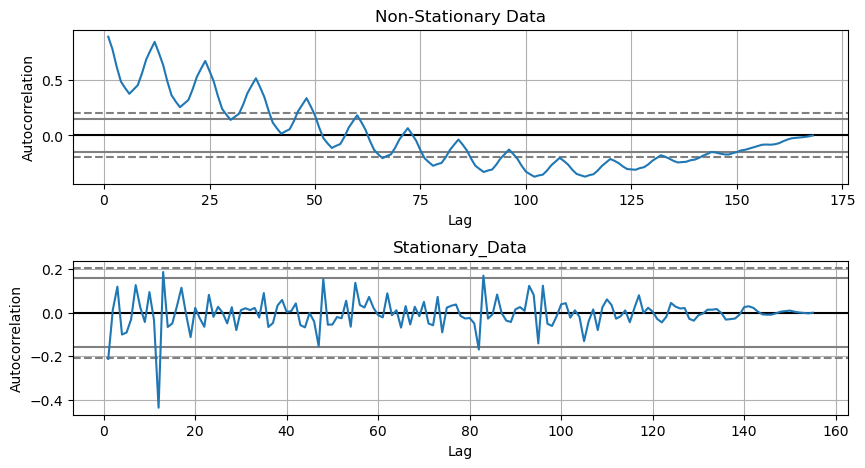

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))
ax1 = autocorrelation_plot(df['Milk Production'], ax = ax1)
ax1.set_title('Non-Stationary Data')
ax2 = autocorrelation_plot(df1['Milk Production'], ax = ax2)
ax2.set_title('Stationary_Data')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('Autocorrelation_plot of Stationary & Non-Stationary.png')
plt.show()

## Model Fitting

_**Getting the p value and q value for the model fitting using `auto_arima` function by passing through some needed parameters, the best model is evaluated by least Akaike Information Criterion[AIC]**_ 

In [17]:
model = auto_arima(df['Milk Production'], d = 1, D = 1, seasonal = True, m = 12, max_order = 6,
                     start_p = 0, start_q = 0, test = 'adf', trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1074.131, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1119.969, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1081.584, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1066.296, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1114.995, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1068.030, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1067.976, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1082.123, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1072.280, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1068.064, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1067.796, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1066.207, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1114.845, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]

_**Defining the summary of the model fitted with `auto_arima` function, here getting various information such as Akaike Information Criterion[AIC], Bayesian Information Criterion[BIC}, Hannan-Quinn Information Criterion[HQIC], Log Likelihood etc. from which we can evaluate the model**_

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Fri, 21 Jul 2023   AIC                           1066.207
Time:                                      13:14:28   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.6190      0.070     -8.825      0.000      -0.757      -0.482
sigma2        52.6908      4.897     10.759      0.000      43.093      62.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

_**Splitting the dataset in training data(85%) and test data(15%)**_

In [19]:
train = df[:int(0.85*len(df))]
test = df[int(0.85*len(df)):]

_**Getting the shapes of training data and test data, so that we can able to know the exact observations in training and test data**_

In [20]:
train.shape, test.shape

((142, 1), (26, 1))

_**Fitting the model in SARIMAX model with the best value got from auto_arima model in the training data and getting the summary of the fitted model**_

In [21]:
model = SARIMAX(train['Milk Production'], order = (1,1,0), seasonal_order = (0,1,1,12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Milk Production   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -445.603
Date:                              Fri, 21 Jul 2023   AIC                            897.205
Time:                                      13:14:28   BIC                            905.785
Sample:                                  01-01-1962   HQIC                           900.691
                                       - 10-01-1973                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2728      0.087     -3.149      0.002      -0.443      -0.103
ma.S.L12      -0.6158      0.086     -7.163      0.000      -0.784      -0.447
sigma2        56.0243      5.765      9.719      0.000      44.726      67.323
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                40.04
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.86
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

_**Plotting the Diagnostic plot for the fitted model to show the best fit of the model and saving it as PNG file**_

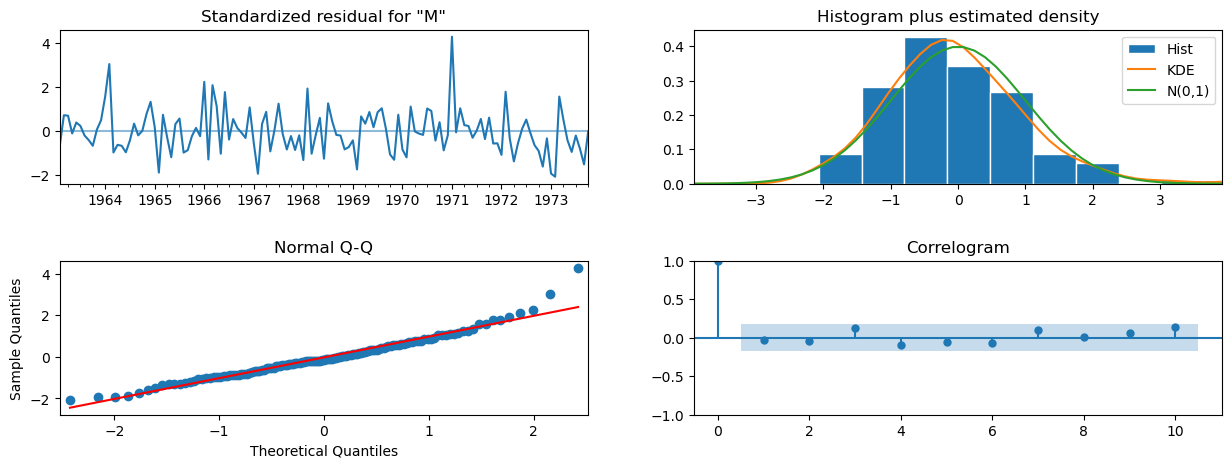

In [22]:
result.plot_diagnostics(figsize = (15,5))
plt.subplots_adjust(hspace = 0.5)
plt.savefig('Diagnostic Plot of Best Model')
plt.show()

_**Predicting the values using test data and renaming it as "Predictions"**_

In [23]:
predictions = result.predict(len(train), len(train) + len(test) - 1, typ = 'levels').rename('Predictions')

_**Comparing the predicted value with actual value in the test data**_

In [24]:
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]:<6.5}, expected = {test['Milk Production'][i]}")

predicted = 752.78, expected = 760.0
predicted = 791.71, expected = 802.0
predicted = 816.61, expected = 828.0
predicted = 775.71, expected = 778.0
predicted = 876.54, expected = 889.0
predicted = 891.67, expected = 902.0
predicted = 952.58, expected = 969.0
predicted = 923.4 , expected = 947.0
predicted = 880.27, expected = 908.0
predicted = 839.96, expected = 867.0
predicted = 792.91, expected = 815.0
predicted = 798.32, expected = 812.0
predicted = 760.53, expected = 773.0
predicted = 799.34, expected = 813.0
predicted = 824.27, expected = 834.0
predicted = 783.37, expected = 782.0
predicted = 884.2 , expected = 892.0
predicted = 899.33, expected = 903.0
predicted = 960.24, expected = 966.0
predicted = 931.06, expected = 937.0
predicted = 887.93, expected = 896.0
predicted = 847.62, expected = 858.0
predicted = 800.57, expected = 817.0
predicted = 805.97, expected = 827.0
predicted = 768.19, expected = 797.0
predicted = 807.0 , expected = 843.0


_**Plotting the line graph with the Predicted value and Test Data value and saving the graph as PNG file**_

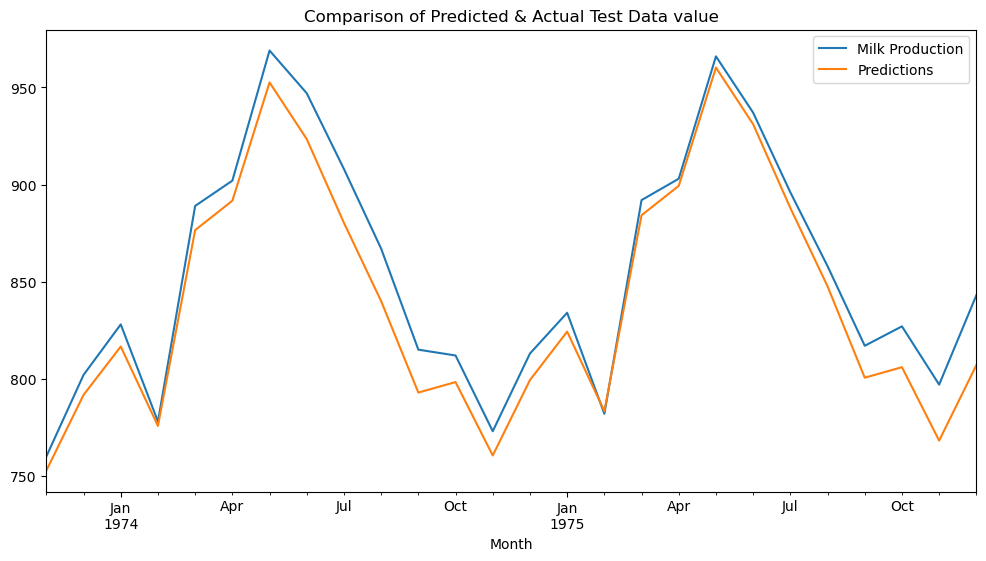

In [25]:
test['Milk Production'].plot(figsize = (12,6))
predictions.plot()
plt.title('Comparison of Predicted & Actual Test Data value')
plt.legend()
plt.savefig('Comparison of Predicted & Actual Test Data value.png')
plt.show()

## Model Evaluation

_**Evaluating the model with the following metrics such as R2 Score, Mean Squared Error, Root Mean Squared Error, Mean Absolute Error and Mean Absolute Percentage Error for the predicted value and test data value**_

In [26]:
print('Evaluation Results for Test Data : \n')
print(' Percenatge of R2 Score : {} %'.format(100*(r2_score(test['Milk Production'],predictions))),'\n')
print(' Mean Squared Error : ',mean_squared_error(test['Milk Production'],predictions),'\n')
print(' Root Mean Squared Error : ',sqrt(mean_squared_error(test['Milk Production'],predictions)),'\n')
print(' Mean Absolute Error : ',mean_absolute_error(test['Milk Production'],predictions),'\n')
print(' Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(test['Milk Production'],predictions)),'\n')

Evaluation Results for Test Data : 

 Percenatge of R2 Score : 92.40433750469683 % 

 Mean Squared Error :  274.9406223175997 

 Root Mean Squared Error :  16.581333550640604 

 Mean Absolute Error :  14.06288842082953 

 Mean Absolute Percentage Error : 1.65 % 



## Model Testing

_**Creating the pickle file with the best model that gives high R2 score for the test data**_

In [27]:
pickle.dump(result,open('Best Model.pkl','wb'))

_**Loading the pickle file and predicting the whole data for testing**_

In [28]:
final_model = pickle.load(open('Best Model.pkl','rb'))
fpred = final_model.predict(0, 167, typ = 'levels')

_**Evaluating the model with the following metrics such as R2 Score, Mean Squared Error, Root Mean Squared Error, Mean Absolute Error and Mean Absolute Percentage Error for the predicted value and whole data**_

In [29]:
print('Evaluation Results for whole Data : \n')
print(' Percenatge of R2 Score : {} %'.format(100*(r2_score(df['Milk Production'],fpred))),'\n')
print(' Mean Squared Error : ',mean_squared_error(df['Milk Production'],fpred),'\n')
print(' Root Mean Squared Error : ',sqrt(mean_squared_error(df['Milk Production'],fpred)),'\n')
print(' Mean Absolute Error : ',mean_absolute_error(df['Milk Production'],fpred),'\n')
print(' Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(df['Milk Production'],fpred)),'\n')

Evaluation Results for whole Data : 

 Percenatge of R2 Score : 73.71069999209308 % 

 Mean Squared Error :  2729.772482498849 

 Root Mean Squared Error :  52.24722463919829 

 Mean Absolute Error :  14.246360984922427 

 Mean Absolute Percentage Error : 2.12 % 



## Forecasting

_**Forecasting the result for the future dates using the loaded model**_

In [30]:
forecast = final_model.predict(start = '1976-01-01', end = '1980-12-01')

_**Plotting the line graph with given data and predicted future data and saving it as PNG file**_

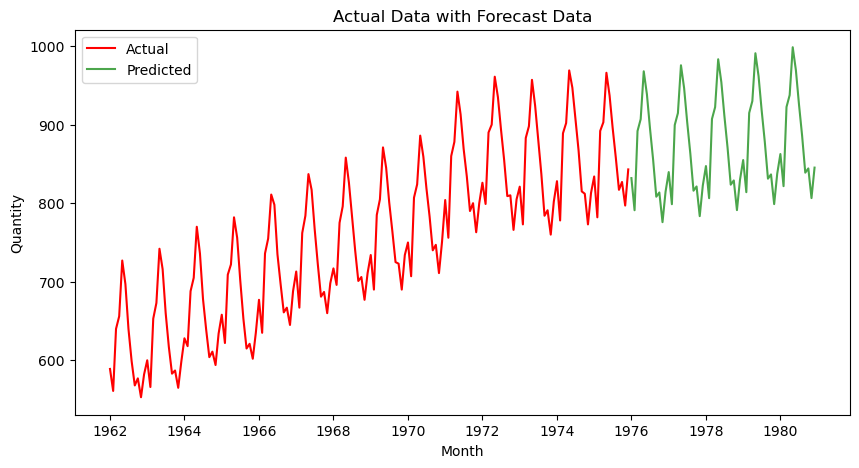

In [31]:
plt.plot(df, color = 'red', label = 'Actual',alpha = 1)
plt.plot(forecast, color = 'green', label = 'Predicted', alpha = 0.7)
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.legend()
plt.title('Actual Data with Forecast Data')
plt.savefig('Actual Data with Forecast Data.png')
plt.show()

_**Making the forecasted value as dataframe, concating it with dataframe and exporting the DataFrame to [Comma Seperated Value]csv file**_

In [32]:
forecast_df=pd.DataFrame(forecast)
forecast_df.rename(columns={'predicted_mean': 'Predicted Future Milk Production'}, inplace=True)
final = pd.concat([df,forecast_df],axis=1)
final['Predicted Future Milk Production'] = final['Predicted Future Milk Production'].round(2)
final.to_csv('Future Predicted Milk Production.csv')